# NBT property log analysis

> **The aim of this analysis is to identify and correct the various types of errors which reach our vm machines and aim to fix them. By analysing the logs and identifying where we are facing the errors we can:**
* improve our websites response rate 
* reduce bounce rate.
* Identify key sources of errors
* Identify key problems within our code base which would be applicable across properties
* Identify platform / property / VM  specific errors 


In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)

In [76]:
# Reading the log file
df = pd.read_csv('combined_error_log.csv',index_col=False)

In [77]:
# Seeing data
df.head(5)

,IP,TIME,PLATFORM,REQ_URL,REQ_FEED,DESC
0,172.24.88.49,21-12-2020 0:0:6,mobile,https://navbharattimes.indiatimes.com/photomazza/business-career/charges-for-different-mode-of-payments-on-online-rail-ticketing-through-irctc/photoshow/63935894.cms,NaN,'Error [ERR_HTTP_HEADERS_SENT]: Cannot set headers after they are sent to the clientat validateHeader (_http_outgoing.js:503:11)at ServerResponse.setHeader (_http_outgoing.js:510:3)at y (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1250837)at Object.<anonymous> (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1255317)at tryCatch (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1245253)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245399at new Promise (<anonymous>)'
1,172.24.88.49,21-12-2020 0:0:20,desktop,https://navbharattimes.indiatimes.com/sports/tennis/spanish-player-garbine-muguruza-not-in-pressure-just-ahead-of-french-open/articleshow/64328093.cms,NaN,'[object Object]'
2,172.24.88.49,21-12-2020 0:0:31,desktop,https://navbharattimes.indiatimes.com/breaking-news-in-hindi/-/articleshow/77776680.cms,NaN,'TypeError: Cannot read property 'pagetype' of undefinedat t.value (/opt/deployment/production/nbtweb_99/dist/server.js:1:1218441)at /opt/deployment/production/nbtweb_99/dist/server.js:1:377828at T (/opt/deployment/production/nbtweb_99/dist/server.js:1:378032)at e.HBEh.t.render (/opt/deployment/production/nbtweb_99/dist/server.js:1:387303)at e.HBEh.t.read (/opt/deployment/production/nbtweb_99/dist/server.js:1:386882)at renderToString (/opt/deployment/production/nbtweb_99/dist/server.js:1:392073)at y (/opt/deployment/production/nbtweb_99/dist/server.js:1:1092749)at Object.<anonymous> (/opt/deployment/production/nbtweb_99/dist/server.js:1:1097825)at tryCatch (/opt/deployment/production/nbtweb_99/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtweb_99/node_modules/regenerator-runtime/runtime.js:303:22)'
3,172.24.88.49,21-12-2020 0:0:34,desktop,https://navbharattimes.indiatimes.com/photomazza/business-career/amitabh-bachhan-invests-in-right-stocks-get-handsome-return/photoshow/53841159.cms,NaN,'Error [ERR_HTTP_HEADERS_SENT]: Cannot set headers after they are sent to the clientat validateHeader (_http_outgoing.js:503:11)at ServerResponse.setHeader (_http_outgoing.js:510:3)at y (/opt/deployment/production/nbtweb_99/dist/server.js:1:1093345)at Object.<anonymous> (/opt/deployment/production/nbtweb_99/dist/server.js:1:1097825)at tryCatch (/opt/deployment/production/nbtweb_99/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtweb_99/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtweb_99/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtweb_99/dist/server.js:1:1087761)at /opt/deployment/production/nbtweb_99/dist/server.js:1:1087907at new Promise (<anonymous>)'
4,172.24.88.49,21-12-2020 0:0:36,desktop,https://navbharattimes.indiatimes.com/sports/cricket/iplt20/photos/ipl-eliminator-kolkata-knight-riders-beat-rajasthan-royal-by-25-runs-match-highlights/andre-russell/photoshow/64294866.cms,NaN,'Error [ERR_HTTP_HEADERS_SENT]: Cannot set headers after they are sent to the clientat validateHeader (_http_outgoing.js:503:11)at ServerResponse.setHeader (_http_outgoing.js:510:3)at y (/opt/deployment/production/nbtweb_99/dist/server.js:1:1093345)at Object.<anonymous> (/opt/deployment/production/nbtweb_99/dist/server.js:1:1097825)at tryCatch (/opt/deployment/

> **Dropping any duplicate types of errors based on the following combination**



In [78]:
df.drop_duplicates(subset=['PLATFORM','REQ_URL', 'REQ_FEED','DESC'], keep='last')
df.shape

(120277, 6)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120277 entries, 0 to 120276
Data columns (total 6 columns):
IP          120277 non-null object
TIME        120277 non-null object
PLATFORM    120277 non-null object
REQ_URL     120277 non-null object
REQ_FEED    13933 non-null object
DESC        120277 non-null object
dtypes: object(6)
memory usage: 5.5+ MB


* **Parsing time and date to get a more accurate analysis if needed**

In [80]:
# Adding parsed time 
# df['TIME'] = df['TIME'].apply(lambda x: x.strip())
# df['PARSED_TIME'] =df['TIME'].apply(lambda x: x[11:].strip())
# df['PARSED_TIME'] = df['PARSED_TIME'].apply(lambda x: x[:x.rindex(':')])
# df['PARSED_DATE'] = df['TIME'].apply(lambda x: x[:11].strip())
# df['PARSED_TIME'].head(30)
# df['PARSED_TIME'] = pd.to_datetime(df['PARSED_TIME'], format='%H:%M')
# df['PARSED_TIME'].head(30)
## Parsing time and date, converting to datetime
df['PARSED_DATE_TIME'] = pd.to_datetime(df['TIME'], format='%d-%m-%Y %H:%M:%S')
df['PARSED_DATE_TIME'].dt.time.head()


hour_labels = [str(x) + '-'+str(x+1) for x in range(23)]
hour_labels.append('23-0')
hour_labels

## Binning the same to make it a categorical variable.
df["BINNED_HOURS"] = pd.cut(df.PARSED_DATE_TIME.dt.hour, bins=24,labels=hour_labels)
df['BINNED_HOURS']

0         0-1 
1         0-1 
2         0-1 
3         0-1 
4         0-1 
5         0-1 
6         0-1 
7         0-1 
8         0-1 
9         0-1 
10        0-1 
11        0-1 
12        0-1 
13        0-1 
14        0-1 
15        0-1 
16        0-1 
17        0-1 
18        0-1 
19        0-1 
20        0-1 
21        0-1 
22        0-1 
23        0-1 
24        0-1 
25        0-1 
26        0-1 
27        0-1 
28        0-1 
29        0-1 
         ...  
120247    23-0
120248    23-0
120249    23-0
120250    23-0
120251    23-0
120252    23-0
120253    23-0
120254    23-0
120255    23-0
120256    23-0
120257    23-0
120258    23-0
120259    23-0
120260    23-0
120261    23-0
120262    23-0
120263    23-0
120264    23-0
120265    23-0
120266    23-0
120267    23-0
120268    23-0
120269    23-0
120270    23-0
120271    23-0
120272    23-0
120273    23-0
120274    23-0
120275    23-0
120276    23-0
Name: BINNED_HOURS, Length: 120277, dtype: category
Categories (24, object): [0-1 < 1

* **Categorizing urls based on page types**

In [81]:
def categorize_url(url):
    template_map = {
        '/amp_':'amp',
        'articleshow':'articleshow',
        'photoshow':'photoshow',
        'photolist':'photolist',
        'videoshow':'videoshow',
        'articlelist':'articlelist',
        'topics':'topics'
    }
    for template in template_map:
        if template in url:
            return template_map[template]
    return 'others'
df['URL_CATEGORY'] = df['REQ_URL'].apply(categorize_url)


**Categorizing Errors based on Error types**

How i found the categories:
1. Initially i was assuming we generally face two types of errors: **404** for invalid feed hit, or **9000ms** where feed responds slowly. However inspecting and grouping feed errors
2. First inspected the df, found **404 and undefined**, started with these as a base along with **null**
3. Characterized others as **"others"** manually inspected others one by one and found: **410 ,403, ['object Object'] timeout and ECONNRESET**


In [82]:
# How i found the categories:
# First inspected the df, found 404 and undefined, started with these as a base along with null
# Characterized others as "others" manually inspected others one by one and
# found: 410 ,403, ['object Object'] timeout
def categorize_error(error):
    #     categories = ['null','undefined','404','410','ERR_HTTP_HEADERS_SENT','9000ms']
    categories = {
       '[object Object]':'[object Object]','undefined':'undefined','404':'404','410':'410','403':'403','ECONNRESET':'ECONNRESET','ERR_HTTP_HEADERS_SENT':'ERR_HTTP_HEADERS_SENT','9000ms':'timeout'       
    }
    for cat in categories:
        if cat in error:
            return categories[cat]
    return 'other'
            
df['ERROR_TYPE'] = df['DESC'].apply(categorize_error)

*  **Further inspection reveals that some urls are broken with '-' '/-' or '%' values in SEO in between. It will be useful if we categorize these.**

In [83]:
# Categories to check where we failed in urls
# Manually inspecting, i found '-/' '/-/' and cases like
df['IS_URL_ERROR'] = df['REQ_URL'].apply(lambda x: '/-/' in x or '-/' in x or '%' in x)

In [84]:
## Some examples
df['REQ_URL'][df['IS_URL_ERROR']].head(5)

2     https://navbharattimes.indiatimes.com/breaking-news-in-hindi/-/articleshow/77776680.cms                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
18    https://navbharattimes.indiatimes.com/lifestyle/family/how-many-days-after-sex-do-you-conceive-in-hindi/amp_articleshow/%E0%A4%AA%E0%A5%8D%E0%A4%B0%E0%A5%87%E0%A4%97%E0%A5%8D%E2%80%8D%E0%A4%A8%E0%A5%87%E0%A4%82%E0%A4%9F-%E0%A4%B9%E0%A5%8B%E0%A4%A8%E0%A5%87-%E0%A4%95%E0%A5%87-%E0%A4%B2%E0%A4%BF%E0%A4%8F-%E0%A4%A6%E0%A4%BF%E0%A4%A8-%E0%A4%AE%E0%A5%87%E0%A4%82-%E0%A4%95%E0%A4%BF%E0%A4%A4%E0%A4%A8%

* **Analysing an error which was frequently occuring. It seems JS was appending this error without giving the actual description, need to analyse how its happening on the urls where it is occuring**

In [85]:
# Very vague type of error
df['DESC'][df['ERROR_TYPE'] == '[object Object]']

1         '[object Object]'
5         '[object Object]'
7         '[object Object]'
8         '[object Object]'
9         '[object Object]'
15        '[object Object]'
16        '[object Object]'
20        '[object Object]'
21        '[object Object]'
23        '[object Object]'
25        '[object Object]'
31        '[object Object]'
33        '[object Object]'
35        '[object Object]'
36        '[object Object]'
37        '[object Object]'
42        '[object Object]'
44        '[object Object]'
48        '[object Object]'
60        '[object Object]'
66        '[object Object]'
70        '[object Object]'
72        '[object Object]'
74        '[object Object]'
78        '[object Object]'
82        '[object Object]'
83        '[object Object]'
85        '[object Object]'
87        '[object Object]'
89        '[object Object]'
                ...        
119770    '[object Object]'
119812    '[object Object]'
119830    '[object Object]'
119869    '[object Object]'
119900    '[object O

In [86]:
# Further inspection reveals that some urls are broken with '-' in between. It will be useful if we categorize these.
df['REQ_URL'][df['ERROR_TYPE'] == '[object Object]']

1         https://navbharattimes.indiatimes.com/sports/tennis/spanish-player-garbine-muguruza-not-in-pressure-just-ahead-of-french-open/articleshow/64328093.cms                                                                                           
5         https://navbharattimes.indiatimes.com/movies/kannada/popcorn-monkey-tiger/articleshow/74304279.cms                                                                                                                                               
7         https://navbharattimes.indiatimes.com/movies/international/brahms-the-boy-2/articleshow/74282691.cms                                                                                                                                             
8         https://navbharattimes.indiatimes.com/movies/international/brahms-the-boy-2/articleshow/74282691.cms                                                                                                                                      

* **Following are the amp urls where the url is correctly formed, but still it fails** 

In [87]:
df['REQ_URL'][(df['URL_CATEGORY'] == 'amp') & ~(df['IS_URL_ERROR'])].head(20)

30     https://navbharattimes.indiatimes.com/lifestyle/beauty-skin/aditi-hao-hydari-played-this-beauty-game-and-explained-her-beauty-style/amp_articleshow/photo_79791558                                           
47     https://navbharattimes.indiatimes.com/lifestyle/health/symptoms-appear-months-ago-before-heart-attack-body-changes-and-symptoms-of-heart-attack-in-hindi/amp_articleshow/photo_75251650                      
112    https://navbharattimes.indiatimes.com/up-breaking-news-live-updates-21-march-2020/amp_liveblog/74741034.cms                                                                                                  
143    https://navbharattimes.indiatimes.com/lifestyle/relationship/coronavirus-lockdown-results-in-scarcity-of-condom-know-how-to-control-sexual-urges-to-avoid-accidental-pregnancy/amp_articleshow/photo_74953676
184    https://navbharattimes.indiatimes.com/lifestyle/health/health-benefits-of-curd-rice-or-dahi-chawal/amp_articleshow/photo_73840643            

### Helper functions for plotting

* Pie chart

In [88]:
def plot_pie_chart(df=df,column="",labels=[],title="",percentage_dist=None):
    if not column:
        return
    plt.figure(figsize=(10,8))
    if percentage_dist:
        column_val_percentage = percentage_dist
    else:
        column_val_percentage =  df[column].value_counts(normalize=True) * 100
    if not labels:
        labels = df[column].value_counts().index
    explode=(0,0.1)
    plt.pie(column_val_percentage,explode=explode,labels=labels, autopct='%.1f%%', 
           shadow=False, startangle=0,   
           pctdistance=1.2,labeldistance=1.4)
    plt.title(title)
    plt.show()

* Percentage vs count - barchart

In [89]:
### Helper function to plot charts
def plot_percentage_and_count(column='',supertitle='',title_count='',title_percentage='',xlabel='',ylabel_count='COUNT',ylabel_percentage='PERCENTAGE',df=df):
    if not column:
        return
    fig,ax= plt.subplots(1,2,figsize=(16,8))
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90)

    bp = sns.barplot(data=df,x=column,y=column,orient='v',estimator=lambda x: len(x) / len(df) * 100,ax=ax[0])
    for rect in bp.patches:
        bp.text (rect.get_x() + rect.get_width() // 2,rect.get_height(),"%.2f%%"% rect.get_height(), weight='bold' )
    ax[0].set_title(title_percentage)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel_percentage)

    ## Error types counts
    sns.countplot(df[column],ax=ax[1])
    ax[1].set_title(title_count)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel_count)

    fig.suptitle(supertitle)

    plt.show()

* Heat map for pivots / grouped data

In [90]:
def plot_heat_map(data=None,title="",xlabel="",ylabel="",cmap='Oranges'):
    if data is None:
        return
    plt.figure(figsize=(16,8))
    sns.heatmap(data,linewidths=.5,annot=True,cmap=cmap,fmt="d")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    

## Visualizing the errors

### Understanding platform level distribution for errors

In [91]:
df['PLATFORM'].value_counts(normalize=True) * 100

desktop    79.184715
mobile     20.815285
Name: PLATFORM, dtype: float64

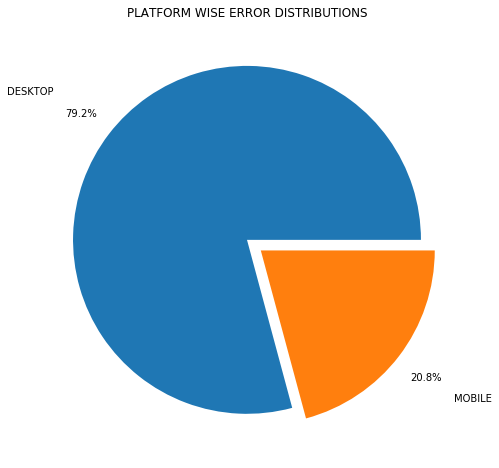

In [92]:
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
plot_pie_chart(column='PLATFORM',labels=['DESKTOP','MOBILE'],title='PLATFORM WISE ERROR DISTRIBUTIONS')

### Identifying where **the url has the problem**

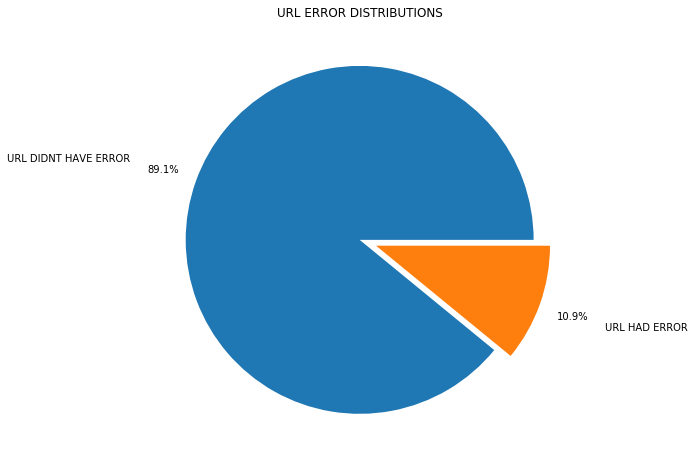

In [93]:
plot_pie_chart(column='IS_URL_ERROR',labels=['URL DIDNT HAVE ERROR','URL HAD ERROR'],title='URL ERROR DISTRIBUTIONS')


> Some examples where url was the problem

In [94]:
df['REQ_URL'][df['IS_URL_ERROR']].head(5)

2     https://navbharattimes.indiatimes.com/breaking-news-in-hindi/-/articleshow/77776680.cms                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
18    https://navbharattimes.indiatimes.com/lifestyle/family/how-many-days-after-sex-do-you-conceive-in-hindi/amp_articleshow/%E0%A4%AA%E0%A5%8D%E0%A4%B0%E0%A5%87%E0%A4%97%E0%A5%8D%E2%80%8D%E0%A4%A8%E0%A5%87%E0%A4%82%E0%A4%9F-%E0%A4%B9%E0%A5%8B%E0%A4%A8%E0%A5%87-%E0%A4%95%E0%A5%87-%E0%A4%B2%E0%A4%BF%E0%A4%8F-%E0%A4%A6%E0%A4%BF%E0%A4%A8-%E0%A4%AE%E0%A5%87%E0%A4%82-%E0%A4%95%E0%A4%BF%E0%A4%A4%E0%A4%A8%

### Further categorizing the url  based  errors on  category of these urls and error types

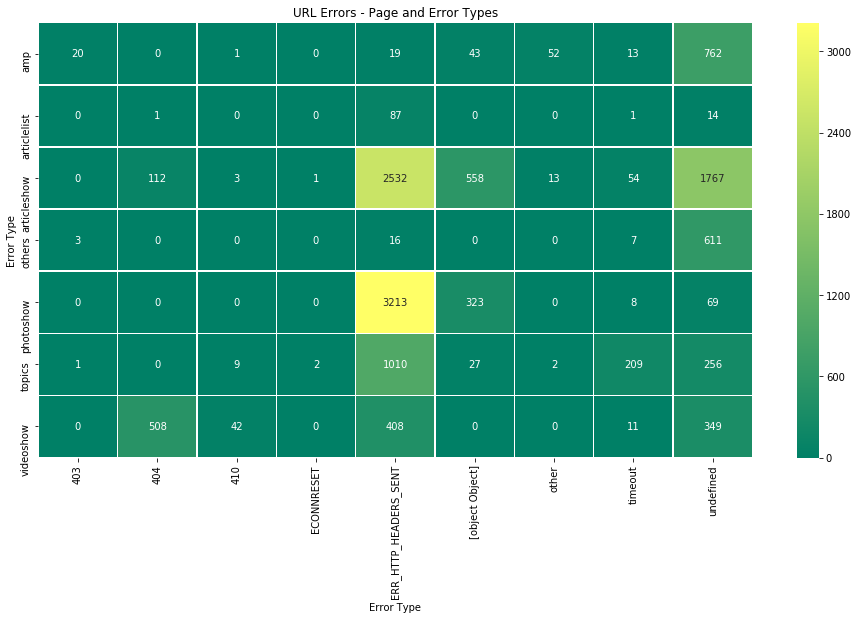

In [95]:
url_errors_grouped =  df[df['IS_URL_ERROR']].groupby(['URL_CATEGORY','ERROR_TYPE']).size().unstack(fill_value=0)
plot_heat_map(data=url_errors_grouped,title='URL Errors - Page and Error Types',xlabel='Error Type',ylabel='Error Type',cmap='summer')


> Above heatmap contains all urls with errors, and error types on those urls

### Understanding about feed errors wherever they occur

In [96]:
## Seeing feed errors vs others
df[~(df['REQ_FEED'].isnull())].count()[0] / df.shape[0] 
# 41.8 percent feederrors 

0.1158409338443759

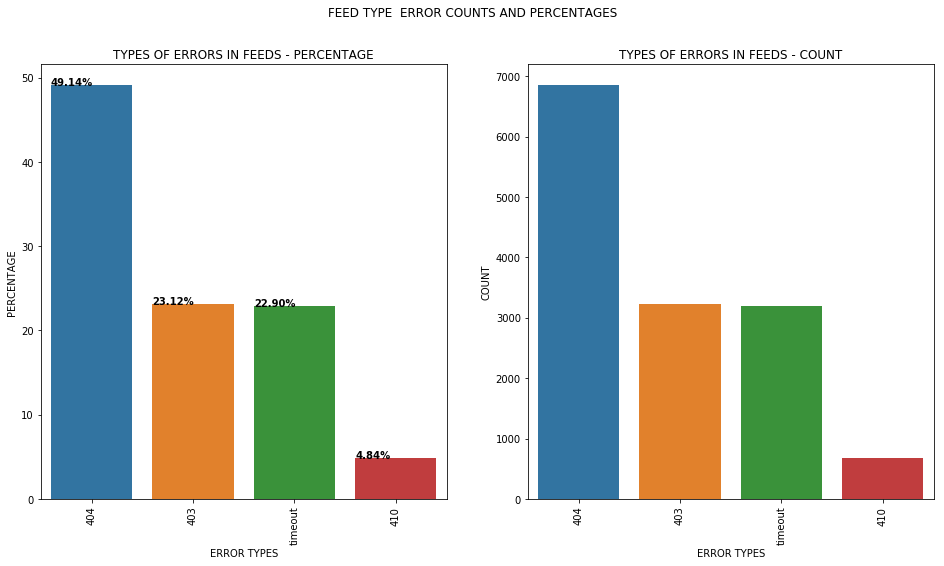

In [97]:
error_types_percentage_feeds = df[(df['ERROR_TYPE'] == '404') | (df['ERROR_TYPE'] == '410') | (df['ERROR_TYPE'] == '403') |  (df['ERROR_TYPE'] == 'timeout')] 

plot_percentage_and_count(df=error_types_percentage_feeds,column='ERROR_TYPE',xlabel="ERROR TYPES",title_count='TYPES OF ERRORS IN FEEDS - COUNT',title_percentage='TYPES OF ERRORS IN FEEDS - PERCENTAGE',supertitle='FEED TYPE  ERROR COUNTS AND PERCENTAGES')
# plot_pie_chart(percentage_dist=error_types_percentage_dist,labels=labels,title="FEED ERROR DISTRIBUTIONS")


> It seems that **majority of the feed errors are 404s**. However some feed errors are **410 and 403** respectively, which are surprising.

### Understanding distribution of errors on various templates

In [98]:
df['URL_CATEGORY'].value_counts()

articleshow    72693
photoshow      17262
videoshow      7794 
articlelist    7306 
amp            6740 
others         4546 
topics         3026 
photolist      910  
Name: URL_CATEGORY, dtype: int64

> **Articlelist + timeout issues bifurcation**

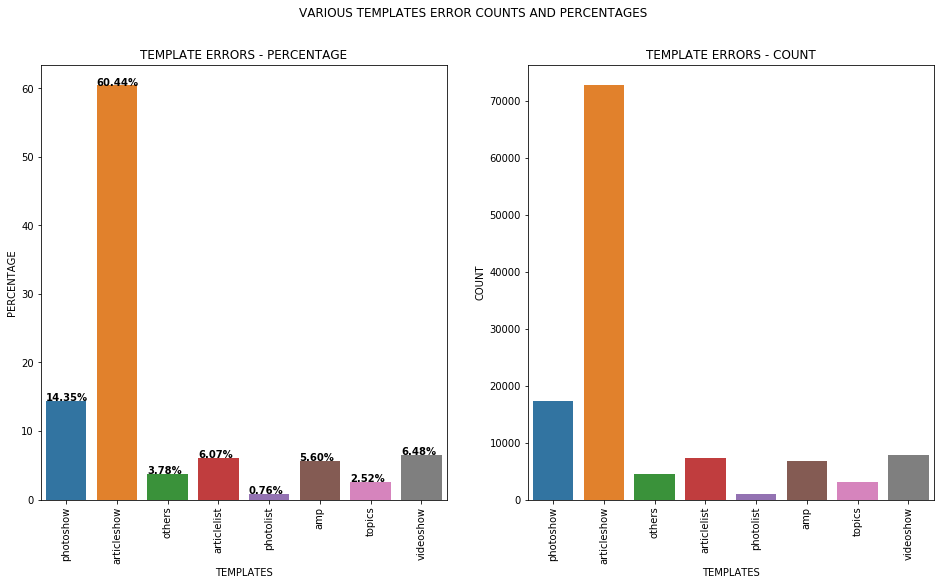

In [99]:
plot_percentage_and_count(column='URL_CATEGORY',xlabel="TEMPLATES",title_count='TEMPLATE ERRORS - COUNT',title_percentage='TEMPLATE ERRORS - PERCENTAGE',supertitle='VARIOUS TEMPLATES ERROR COUNTS AND PERCENTAGES')

> It seems that articlelist has the highest number of errors, followed by articleshow,amp and videoshow

### Understanding distribution of various error types

In [100]:
df['ERROR_TYPE'].value_counts()

ERR_HTTP_HEADERS_SENT    55657
[object Object]          33620
undefined                16645
404                      6855 
403                      3226 
timeout                  3195 
410                      675  
other                    390  
ECONNRESET               14   
Name: ERROR_TYPE, dtype: int64

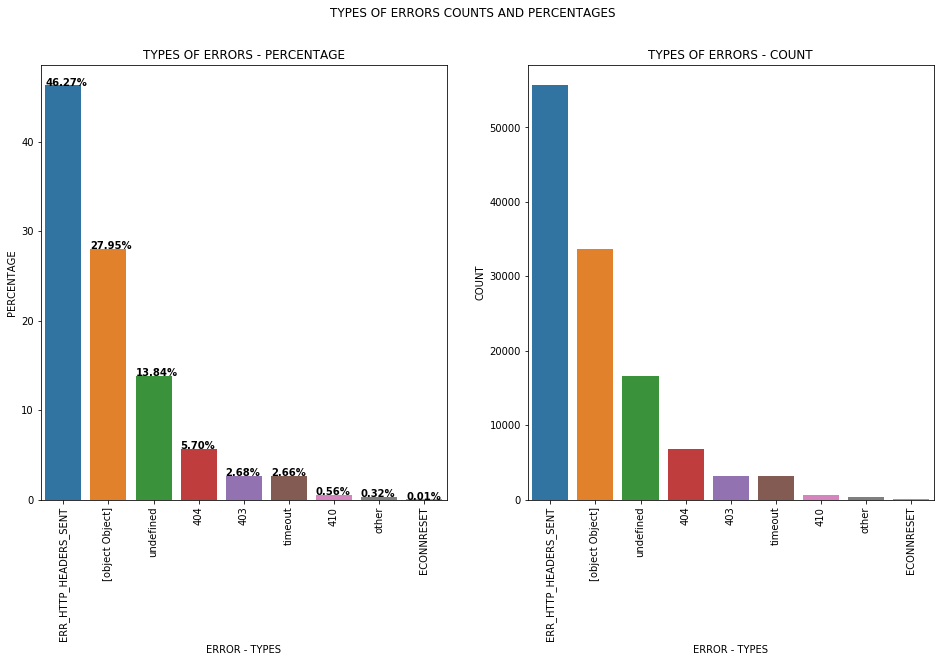

In [101]:
plot_percentage_and_count(column='ERROR_TYPE',xlabel="ERROR - TYPES",title_count='TYPES OF ERRORS - COUNT',title_percentage='TYPES OF ERRORS - PERCENTAGE',supertitle='TYPES OF ERRORS COUNTS AND PERCENTAGES')

### Error type vs pagetype heatmap

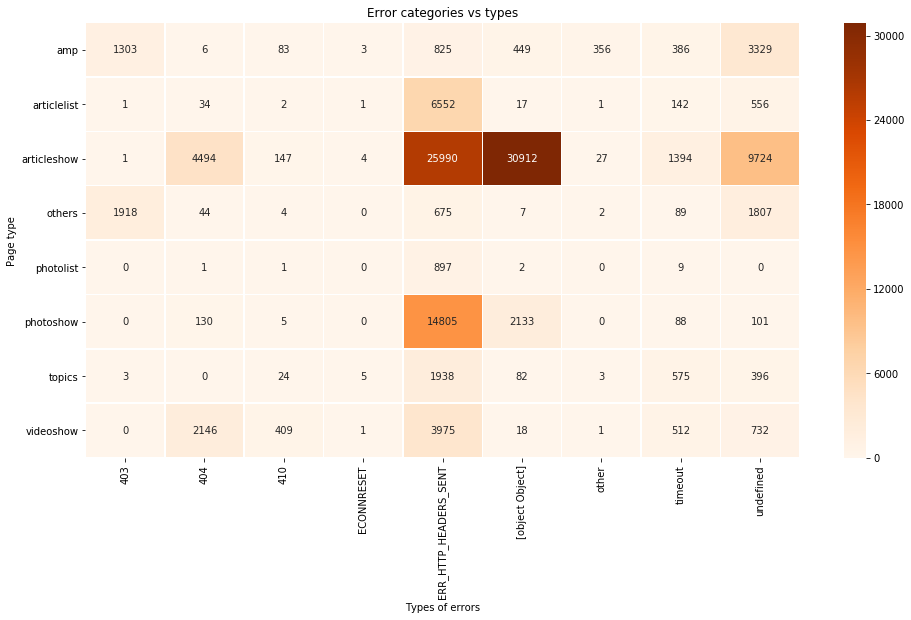

In [102]:
# Creating what type of templates have what type of errors
categories_vs_error_grouped =  df.groupby(['URL_CATEGORY','ERROR_TYPE']).size().unstack(fill_value=0)
plot_heat_map(data=categories_vs_error_grouped,title='Error categories vs types',xlabel='Types of errors',ylabel='Page type',cmap='Oranges')

### Checking if time plays a factor in errors - Templates and Error Types


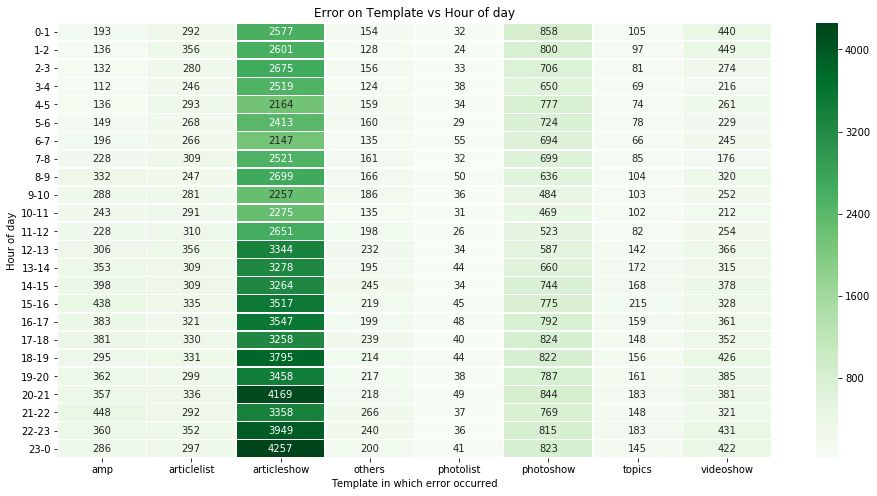

In [103]:
# Creating what type of templates have what type of errors

time_vs_url_category =  df.groupby(['BINNED_HOURS','URL_CATEGORY']).size().unstack(fill_value=0)

plot_heat_map(data=time_vs_url_category,title='Error on Template vs Hour of day',xlabel='Template in which error occurred',ylabel='Hour of day',cmap='Greens')

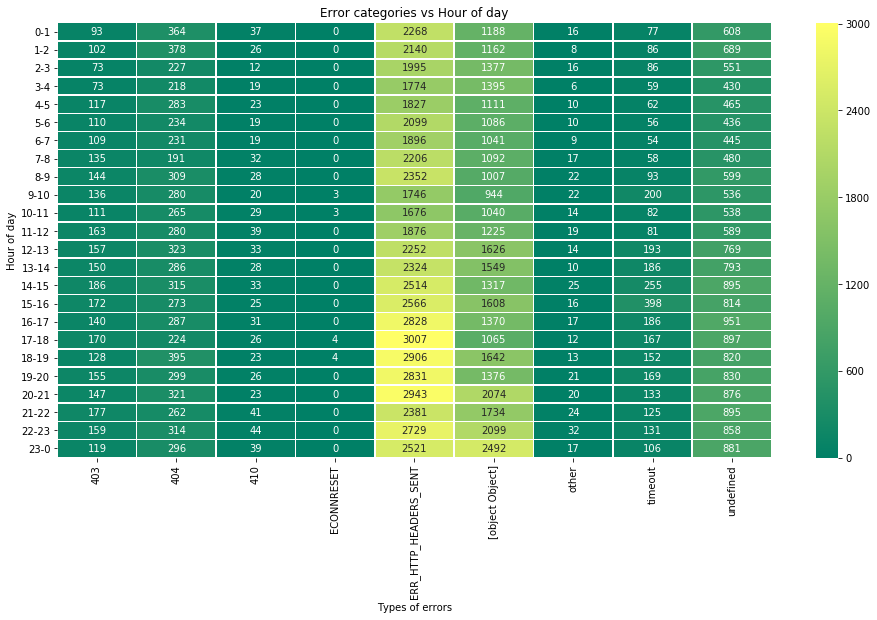

In [104]:
# Creating what type of templates have what type of errors
categories_vs_error_hour_of_day =  df.groupby(['BINNED_HOURS','ERROR_TYPE']).size().unstack(fill_value=0)
plot_heat_map(data=categories_vs_error_hour_of_day,title='Error categories vs Hour of day',xlabel='Types of errors',ylabel='Hour of day',cmap='summer')



> Improvements

* BOT url - classification
* ARticlelist 404s - Feed urls / Timeout ratio
* Amp pages ampnext / vs cases
* '%' url check if correctly parsed

### Seeing where timeouts are happening

In [105]:
timed_out_df = df[df['ERROR_TYPE'] =='timeout']
timed_out_df.head(5)

,IP,TIME,PLATFORM,REQ_URL,REQ_FEED,DESC,PARSED_DATE_TIME,BINNED_HOURS,URL_CATEGORY,ERROR_TYPE,IS_URL_ERROR
22,172.24.88.49,21-12-2020 0:2:48,desktop,https://navbharattimes.indiatimes.com/lifestyle/family/how-second-pregnancy-symptoms-are-different-in-hindi/articleshow/75197921.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_videoshow/feedback.cms?feedtype=sjson,'Error: timeout of 9000ms exceeded',2020-12-21 00:02:48,0-1,articleshow,timeout,False
160,172.24.88.49,21-12-2020 0:15:46,desktop,https://navbharattimes.indiatimes.com/state/maharashtra/other-cities/people-have-started-working-hard-to-resettle-after-flood-water-decreased-in-maharashtra/articleshow/70737865.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articlelist/47106580.cms?feedtype=sjson,'Error: timeout of 9000ms exceeded',2020-12-21 00:15:46,0-1,articleshow,timeout,False
166,172.24.88.49,21-12-2020 0:16:23,desktop,https://navbharattimes.indiatimes.com/state/uttar-pradesh/ghaziabad/sunderdeep-school-gets-best-techno-award/articleshow/67166322.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articleshow.cms?feedtype=sjson&version=v9&msid=67706871,'Error: timeout of 9000ms exceeded',2020-12-21 00:16:23,0-1,articleshow,timeout,False
236,172.24.88.49,21-12-2020 0:23:36,desktop,https://navbharattimes.indiatimes.com/metro/lucknow/administration/yogi-adityanath-issued-guidelines-of-no-idol-installation-on-streets-during-festivals/videoshow/feedback.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_videoshow/feedback.cms?feedtype=sjson,'Error: timeout of 9000ms exceeded',2020-12-21 00:23:36,0-1,videoshow,timeout,False
270,172.24.88.49,21-12-2020 0:26:24,desktop,https://navbharattimes.indiatimes.com/india/armed-forces-advice-government-to-plan-six-months-plan-to-destroy-terror-network-active-in-pok/articleshow/54667756.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articleshow.cms?feedtype=sjson&version=v9&msid=54667756,'Error: timeout of 9000ms exceeded',2020-12-21 00:26:24,0-1,articleshow,timeout,False


**Percentage of errors w.r.t total number of errors**

In [106]:
timed_out_df.shape[0] / df.shape[0] * 100

2.656368216699785

In [107]:
timed_out_df.PLATFORM.value_counts()

desktop    2399
mobile     796 
Name: PLATFORM, dtype: int64

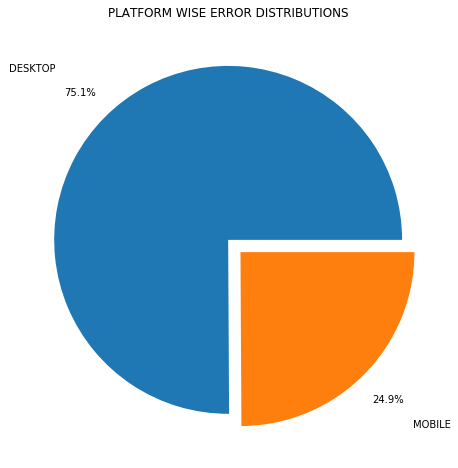

In [108]:
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
percentage_dist = timed_out_df.PLATFORM.value_counts(normalize=True) * 100
plot_pie_chart(df=timed_out_df,column='PLATFORM',labels=['DESKTOP','MOBILE'],title='PLATFORM WISE ERROR DISTRIBUTIONS')

**Heatmap platform wise timeouts**

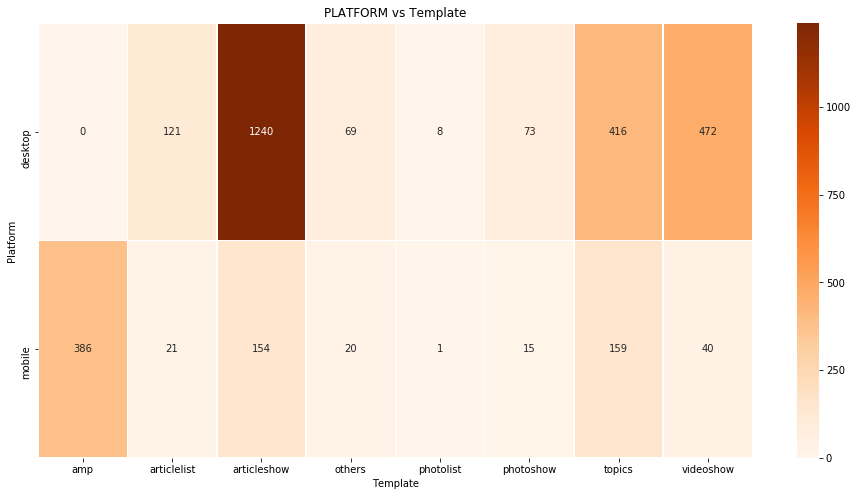

In [109]:
# Creating what type of templates have what type of errors
platforms_vs_templates_timeouts =  timed_out_df.groupby(['PLATFORM','URL_CATEGORY']).size().unstack(fill_value=0)
plot_heat_map(data=platforms_vs_templates_timeouts,title='PLATFORM vs Template',xlabel='Template',ylabel='Platform',cmap='Oranges')



### Checking where amp pages are failing and how

In [110]:
amp_errors_df = df[df['URL_CATEGORY'] == 'amp']

In [111]:

amp_errors_df.PLATFORM.value_counts()

mobile    6740
Name: PLATFORM, dtype: int64

In [113]:
amp_errors_df.head()

,IP,TIME,PLATFORM,REQ_URL,REQ_FEED,DESC,PARSED_DATE_TIME,BINNED_HOURS,URL_CATEGORY,ERROR_TYPE,IS_URL_ERROR
18,172.24.88.49,21-12-2020 0:2:23,mobile,https://navbharattimes.indiatimes.com/lifestyle/family/how-many-days-after-sex-do-you-conceive-in-hindi/amp_articleshow/%E0%A4%AA%E0%A5%8D%E0%A4%B0%E0%A5%87%E0%A4%97%E0%A5%8D%E2%80%8D%E0%A4%A8%E0%A5%87%E0%A4%82%E0%A4%9F-%E0%A4%B9%E0%A5%8B%E0%A4%A8%E0%A5%87-%E0%A4%95%E0%A5%87-%E0%A4%B2%E0%A4%BF%E0%A4%8F-%E0%A4%A6%E0%A4%BF%E0%A4%A8-%E0%A4%AE%E0%A5%87%E0%A4%82-%E0%A4%95%E0%A4%BF%E0%A4%A4%E0%A4%A8%E0%A5%80-%E0%A4%AC%E0%A4%BE%E0%A4%B0-%E0%A4%B8%E0%A5%87%E0%A4%95%E0%A5%8D%E2%80%8D%E0%A4%B8-%E0%A4%95%E0%A4%B0%E0%A4%A8%E0%A4%BE-%E0%A4%B9%E0%A5%88-%E0%A4%9C%E0%A4%B0%E0%A5%82%E0%A4%B0%E0%A5%80,NaN,'TypeError: Cannot read property 'ampnext' of undefinedat r (/opt/deployment/production/nbtmweb_123/dist/server.js:1:604978)at Object.<anonymous> (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1254966)at tryCatch (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1245253)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245399at new Promise (<anonymous>)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245197at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1255743',2020-12-21 00:02:23,0-1,amp,undefined,True
30,172.24.88.49,21-12-2020 0:3:56,mobile,https://navbharattimes.indiatimes.com/lifestyle/beauty-skin/aditi-hao-hydari-played-this-beauty-game-and-explained-her-beauty-style/amp_articleshow/photo_79791558,NaN,'TypeError: Cannot read property 'ampnext' of undefinedat r (/opt/deployment/production/nbtmweb_123/dist/server.js:1:604978)at Object.<anonymous> (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1254966)at tryCatch (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1245253)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245399at new Promise (<anonymous>)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245197at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1255743',2020-12-21 00:03:56,0-1,amp,undefined,False
47,172.24.88.49,21-12-2020 0:6:17,mobile,https://navbharattimes.indiatimes.com/lifestyle/health/symptoms-appear-months-ago-before-heart-attack-body-changes-and-symptoms-of-heart-attack-in-hindi/amp_articleshow/photo_75251650,NaN,'TypeError: Cannot read property 'ampnext' of undefinedat r (/opt/deployment/production/nbtmweb_123/dist/server.js:1:604978)at Object.<anonymous> (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1254966)at tryCatch (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1245253)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245399at new Promise (<anonymous>)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245197at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1255743',2020-12-21 00:06:17,0-1,amp,undefined,False
112,172.24.88.49,21-12-2020 0:11:54,mobile,https:

In [114]:
amp_errors_df.ERROR_TYPE.value_counts()

undefined                3329
403                      1303
ERR_HTTP_HEADERS_SENT    825 
[object Object]          449 
timeout                  386 
other                    356 
410                      83  
404                      6   
ECONNRESET               3   
Name: ERROR_TYPE, dtype: int64

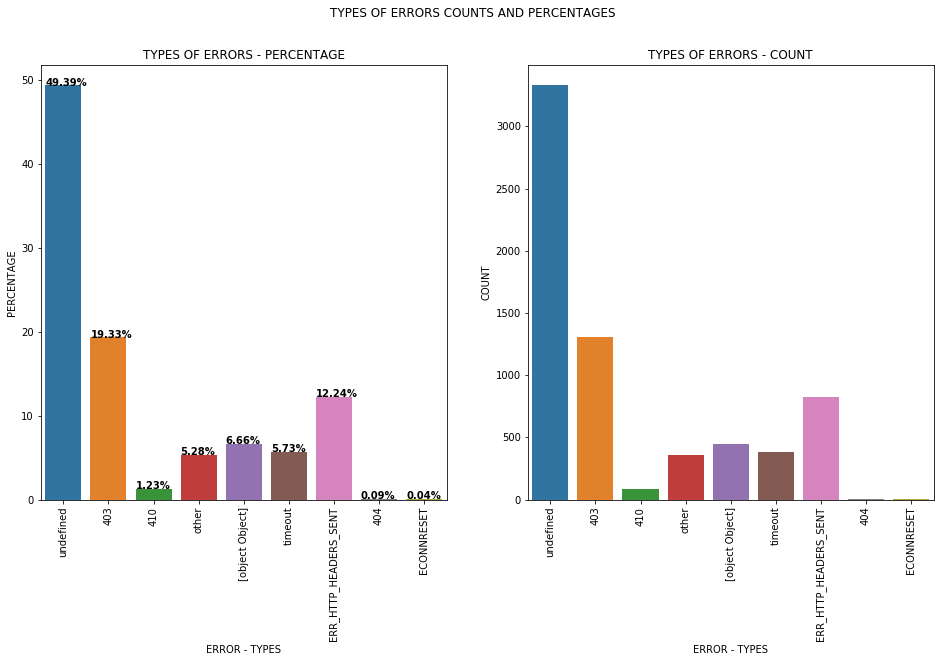

In [115]:
plot_percentage_and_count(df=amp_errors_df,column='ERROR_TYPE',xlabel="ERROR - TYPES",title_count='TYPES OF ERRORS - COUNT',title_percentage='TYPES OF ERRORS - PERCENTAGE',supertitle='TYPES OF ERRORS COUNTS AND PERCENTAGES')

In [122]:
amp_errors_df[amp_errors_df['ERROR_TYPE'] =='undefined']

,IP,TIME,PLATFORM,REQ_URL,REQ_FEED,DESC,PARSED_DATE_TIME,BINNED_HOURS,URL_CATEGORY,ERROR_TYPE,IS_URL_ERROR
18,172.24.88.49,21-12-2020 0:2:23,mobile,https://navbharattimes.indiatimes.com/lifestyle/family/how-many-days-after-sex-do-you-conceive-in-hindi/amp_articleshow/%E0%A4%AA%E0%A5%8D%E0%A4%B0%E0%A5%87%E0%A4%97%E0%A5%8D%E2%80%8D%E0%A4%A8%E0%A5%87%E0%A4%82%E0%A4%9F-%E0%A4%B9%E0%A5%8B%E0%A4%A8%E0%A5%87-%E0%A4%95%E0%A5%87-%E0%A4%B2%E0%A4%BF%E0%A4%8F-%E0%A4%A6%E0%A4%BF%E0%A4%A8-%E0%A4%AE%E0%A5%87%E0%A4%82-%E0%A4%95%E0%A4%BF%E0%A4%A4%E0%A4%A8%E0%A5%80-%E0%A4%AC%E0%A4%BE%E0%A4%B0-%E0%A4%B8%E0%A5%87%E0%A4%95%E0%A5%8D%E2%80%8D%E0%A4%B8-%E0%A4%95%E0%A4%B0%E0%A4%A8%E0%A4%BE-%E0%A4%B9%E0%A5%88-%E0%A4%9C%E0%A4%B0%E0%A5%82%E0%A4%B0%E0%A5%80,NaN,'TypeError: Cannot read property 'ampnext' of undefinedat r (/opt/deployment/production/nbtmweb_123/dist/server.js:1:604978)at Object.<anonymous> (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1254966)at tryCatch (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1245253)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245399at new Promise (<anonymous>)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245197at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1255743',2020-12-21 00:02:23,0-1,articleshow,undefined,True
30,172.24.88.49,21-12-2020 0:3:56,mobile,https://navbharattimes.indiatimes.com/lifestyle/beauty-skin/aditi-hao-hydari-played-this-beauty-game-and-explained-her-beauty-style/amp_articleshow/photo_79791558,NaN,'TypeError: Cannot read property 'ampnext' of undefinedat r (/opt/deployment/production/nbtmweb_123/dist/server.js:1:604978)at Object.<anonymous> (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1254966)at tryCatch (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1245253)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245399at new Promise (<anonymous>)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245197at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1255743',2020-12-21 00:03:56,0-1,articleshow,undefined,False
47,172.24.88.49,21-12-2020 0:6:17,mobile,https://navbharattimes.indiatimes.com/lifestyle/health/symptoms-appear-months-ago-before-heart-attack-body-changes-and-symptoms-of-heart-attack-in-hindi/amp_articleshow/photo_75251650,NaN,'TypeError: Cannot read property 'ampnext' of undefinedat r (/opt/deployment/production/nbtmweb_123/dist/server.js:1:604978)at Object.<anonymous> (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1254966)at tryCatch (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_123/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_123/dist/server.js:1:1245253)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245399at new Promise (<anonymous>)at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1245197at /opt/deployment/production/nbtmweb_123/dist/server.js:1:1255743',2020-12-21 00:06:17,0-1,articleshow,undefined,False
143,172.24.88.49,21-12-20

In [116]:
def categorize_url_amp(url):
    template_map = {
        '_articleshow':'articleshow',
        '_photoshow':'photoshow',
        '_photolist':'photolist',
        '_videoshow':'videoshow',
        '_articlelist':'articlelist',
        '_liveblog':'liveblog',
        '_topics':'topics'
    }
    for template in template_map:
        if template in url:
            return template_map[template]
    return 'others'
amp_errors_df['URL_CATEGORY'] = amp_errors_df['REQ_URL'].apply(categorize_url_amp)


/home/abhinav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


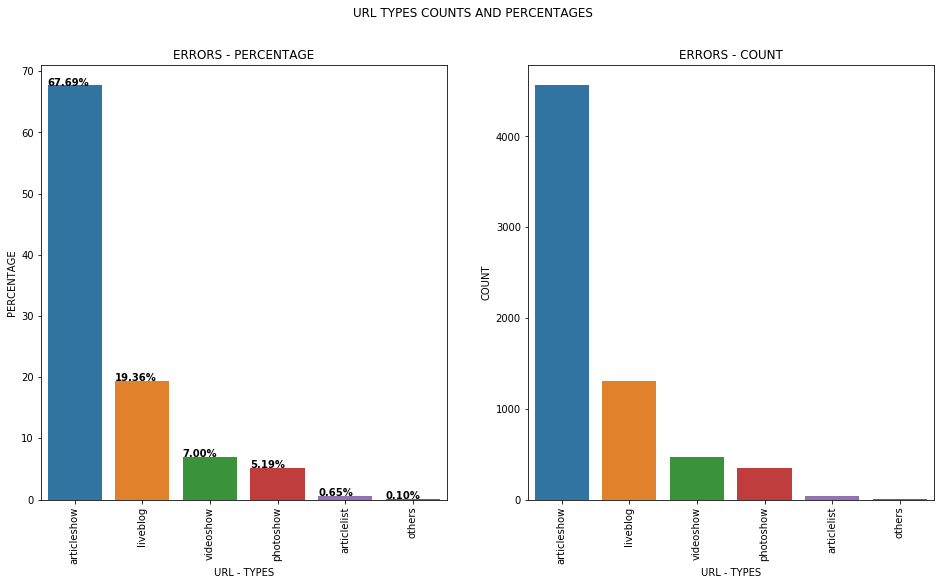

In [117]:
plot_percentage_and_count(df=amp_errors_df,column='URL_CATEGORY',xlabel="URL - TYPES",title_count='ERRORS - COUNT',title_percentage='ERRORS - PERCENTAGE',supertitle='URL TYPES COUNTS AND PERCENTAGES')

* **Understanding 'others'**

In [121]:
# Only 7 records in others categories
amp_errors_df[amp_errors_df['URL_CATEGORY'] =='others'].head(7)

,IP,TIME,PLATFORM,REQ_URL,REQ_FEED,DESC,PARSED_DATE_TIME,BINNED_HOURS,URL_CATEGORY,ERROR_TYPE,IS_URL_ERROR
10179,172.24.88.49,21-12-2020 17:50:7,mobile,https://navbharattimes.indiatimes.com/movie-masti/movie-review/kesari-movie-review-in-hindi/amp_moviereview/68496520.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articleshow.cms?feedtype=sjson&version=v9&msid=64112716,'Error: timeout of 9000ms exceeded',2020-12-21 17:50:07,17-18,others,timeout,False
13568,172.24.88.49,21-12-2020 22:28:8,mobile,https://navbharattimes.indiatimes.com/movie-masti/movie-review/dabangg-3-movie-review-in-hindi/amp_moviereview/72890273.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articleshow.cms?feedtype=sjson&version=v9&msid=72331400,'Error: timeout of 9000ms exceeded',2020-12-21 22:28:08,22-23,others,timeout,False
13569,172.24.88.49,21-12-2020 22:28:8,mobile,https://navbharattimes.indiatimes.com/movie-masti/movie-review/dabangg-3-movie-review-in-hindi/amp_moviereview/72890273.cms,NaN,'TypeError: Cannot read property 'ampnext' of undefinedat r (/opt/deployment/production/nbtmweb_124/dist/server.js:1:623937)at Object.<anonymous> (/opt/deployment/production/nbtmweb_124/dist/server.js:1:1278273)at tryCatch (/opt/deployment/production/nbtmweb_124/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_124/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_124/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_124/dist/server.js:1:1268560)at /opt/deployment/production/nbtmweb_124/dist/server.js:1:1268706at new Promise (<anonymous>)at /opt/deployment/production/nbtmweb_124/dist/server.js:1:1268504at /opt/deployment/production/nbtmweb_124/dist/server.js:1:1279050',2020-12-21 22:28:08,22-23,others,undefined,False
15265,172.24.88.49,22-12-2020 0:47:0,mobile,https://navbharattimes.indiatimes.com/video/news/amp_videolist/4901886.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_videoshow/12750076.cms?feedtype=sjson,'Error: timeout of 9000ms exceeded',2020-12-22 00:47:00,0-1,others,timeout,False
52682,172.24.88.49,23-12-2020 8:12:0,mobile,https://navbharattimes.indiatimes.com/elections/lok-sabha-elections/amp_results/69253542.cms,NaN,'ReferenceError: _electionConfig is not definedat d (/opt/deployment/production/nbtmweb_125/dist/server.js:1:182930)at /opt/deployment/production/nbtmweb_125/dist/server.js:1:183372at /opt/deployment/production/nbtmweb_125/node_modules/redux-thunk/lib/index.js:11:18at Function.z.fetchData (/opt/deployment/production/nbtmweb_125/dist/server.js:1:1601109)at Function.i.function.i.fetchData.t.fetchData (/opt/deployment/production/nbtmweb_125/dist/server.js:1:1418828)at /opt/deployment/production/nbtmweb_125/dist/server.js:1:1269569at Array.map (<anonymous>)at c (/opt/deployment/production/nbtmweb_125/dist/server.js:1:1269395)at /opt/deployment/production/nbtmweb_125/dist/server.js:1:1277987at /opt/deployment/production/nbtmweb_125/node_modules/react-router/lib/match.js:67:5',2020-12-23 08:12:00,8-9,others,other,False
89429,172.24.88.49,26-12-2020 17:38:26,mobile,https://navbharattimes.indiatimes.com/elections/lok-sabha-elections/amp_results/69253542.cms,NaN,'ReferenceError: _electionConfig is not definedat d (/opt/deployment/production/nbtmweb_126/dist/server.js:1:182930)at /opt/deployment/production/nbtmweb_126/dist/server.js:1:183372at /opt/deployment/production/nbtmweb_126/node_modules/redux-thunk/lib/index.js:11:18at Function.z.fetchData (/opt/deployment/production/nbtmweb_126/dist/server.js:1:1601271)at Function.i.function.i.fetchData.t.fetchData (/opt/deployment/production/nbtmweb_126/dist/server.js:1:1418990)at /opt/deployment/production/nbtmweb_126/dist/server.js:1:1269731at Array.map (<anonymous>)at c (/opt/deployment/production/nbtmweb_126/dist/server.js:1:1269557)at /opt/deployment/production/nbtmweb